# Model training
In this notebook a model is created, trained and evaluated on the test set.
<br>MLFlow is used to track the experiments and push a model to production.

In [96]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import mlflow

from countryguess.data import Dataset, TestDataset, ValDataset, TripletDataset
from countryguess.utils import poly_to_img

## Data

### Initialise datasets

In [2]:
ref_data = Dataset()
train_data = TripletDataset()
val_data = ValDataset()
test_data = TestDataset()

### Ploting the data

#### Training data

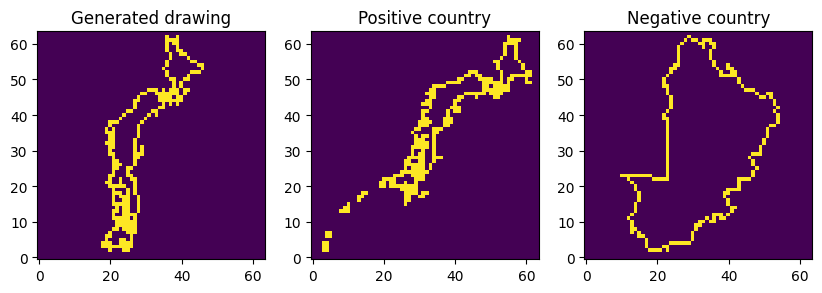

In [19]:
idx = random.randint(0, len(train_data) - 1)
sample = train_data[idx]

#Plotting
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title("Generated drawing") 
axs[1].imshow(sample["pos_img"], interpolation='nearest', origin='lower')
axs[1].set_title("Positive country") 
axs[2].imshow(sample["neg_img"], interpolation='nearest', origin='lower')
axs[2].set_title("Negative country") 
plt.show()

#### Validation set

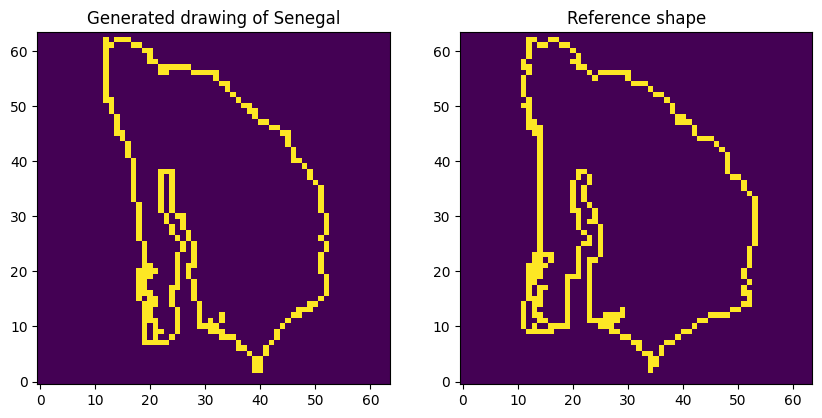

In [9]:
idx = random.randint(0, len(val_data) - 1)
sample = val_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"Generated drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

#### Test set (user drawings)

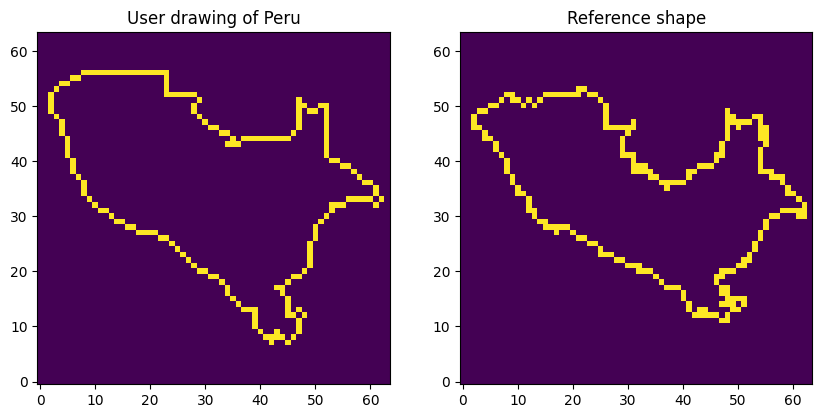

In [26]:
idx = random.randint(0, len(test_data) - 1)
sample = test_data[idx]

#Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(sample["drawing"], interpolation='nearest', origin='lower')
axs[0].set_title(f"User drawing of {sample['country_name']}") 

img = poly_to_img(ref_data.from_country_name(sample['country_name']), ref_data.shape)
axs[1].imshow(img, interpolation='nearest', origin='lower')
axs[1].set_title("Reference shape")
plt.show()

## Training model

### Define Model
The model should have a load reference method and a rank countries method

In [3]:
class Model(nn.Module):
    def __init__(self, dims=[1, 16, 32, 64, 80, 16*80, 96], shape=(64, 64)):
        super().__init__()
        self.shape = shape
        self._ref_countries = None
        self.conv_1 = self.conv_block(dims[0], dims[1])
        self.conv_2 = self.conv_block(dims[1], dims[2])
        self.conv_3 = self.conv_block(dims[2], dims[3])
        self.conv_4 = self.conv_block(dims[3], dims[4])
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(dims[5], dims[6])

    
    def conv_block(self, in_dim, out_dim):
        return nn.Sequential(
            nn.Conv2d(in_dim, out_dim, 3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
            nn.Conv2d(out_dim, out_dim, 3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
            nn.Conv2d(out_dim, out_dim, 3, padding=1),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
            nn.MaxPool2d(2))


    def __call__(self, x):
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = x.flatten(start_dim=1)
        x = self.dropout(x)
        x = self.linear(x)
        
        return x

    
    def load_reference(self, ref_data):
        self._ref_countries = {}
        for idx in range(len(ref_data)):
            img = poly_to_img(ref_data[idx], ref_data.shape)
            embedding = self(torch.tensor(img[None, None, :, :], dtype=torch.float32).to(device))
            self._ref_countries[ref_data.country_name[idx]] = embedding

    
    @torch.no_grad
    def rank_countries(self, drawings):
        embedding = self(drawings)
        countries = []
        distances = []

        if not self._ref_countries:
            raise Exception("First the reference dataset needs to be loaded!")            

        for country, ref_emb in self._ref_countries.items():
            countries.append(country)
            distance = torch.linalg.norm(embedding - ref_emb, axis=-1)
            distances.append(distance.cpu())

        return countries, np.array(distances)

In [4]:
def triplet_mining(anc_emb, pos_emb, neg_emb, pos_idx, neg_idx):
    #All combinations
    anc_emb = anc_emb.tile((anc_emb.shape[0], 1))
    pos_emb = pos_emb.tile((pos_emb.shape[0], 1))
    neg_emb = neg_emb.repeat(neg_emb.shape[0], 1)
    pos_idx = pos_idx.tile((pos_idx.shape[0]))
    neg_idx = neg_idx.repeat((neg_idx.shape[0]))
    
    #Mask valid triplets
    valid = pos_idx!=neg_idx
    
    return anc_emb[valid], pos_emb[valid], neg_emb[valid]

In [5]:
def eval_fn(model, batch):
    drawings = batch['drawing'][:, None, :, :].type(torch.float32).to(device)
    countries, distances = model.rank_countries(drawings)
    all_rank = np.argsort(distances, axis=0)
    index = [countries.index(country) for country in batch['country_name']]
    rank = np.argmax(all_rank==index, axis=0)

    return rank

### Train model

Run the following command to start the MLFlow Tracking UI: `mlflow ui --port 5001`
<br>Access the MLFlow Tracking UI at: http://127.0.0.1:5001

In [97]:
device = torch.device("mps")

In [98]:
mlflow.set_experiment("triplet_model")

params = {"embedding_size": 128,
          "learning_rate": 0.008, 
          "margin": 0.8,
          "temperature": 0.6,
          "nr_epochs": 96}

model = Model(dims=[1, 16, 32, 64, 80, 16*80, params["embedding_size"]]).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=params['learning_rate'])
triplet_loss = nn.TripletMarginLoss(margin=params['margin'])

In [99]:
train_data = TripletDataset(temp=params["temperature"])
val_data = ValDataset(temp=params["temperature"])

train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(val_data, batch_size=32)

In [100]:
mlflow.start_run()
mlflow.log_params(params)

#Start training
for epoch in range(params['nr_epochs']):
    losses = []        
    model.train()
    for batch in train_dl:
        optimizer.zero_grad()
        anc_emb = model(batch['drawing'][:, None, :, :].type(torch.float32).to(device))
        pos_emb = model(batch['pos_img'][:, None, :, :].type(torch.float32).to(device))
        neg_emb = model(batch['neg_img'][:, None, :, :].type(torch.float32).to(device))

        #Mine triplets
        anc_emb, pos_emb, neg_emb = triplet_mining(anc_emb, pos_emb, neg_emb, 
                                                   batch["pos_idx"], batch["neg_idx"])

        loss = triplet_loss(anc_emb, pos_emb, neg_emb)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

    mlflow.log_metric("loss", np.mean(losses), epoch)
    
    print('Epoch: {}\t loss: {:.3f}'.format(epoch, np.mean(losses)))

    if (epoch+1)%4==0:
        ranking = np.array([])
        model.eval()
        model.load_reference(ref_data)
        for batch in val_dl:
            rank = eval_fn(model, batch)
            ranking = np.append(ranking, rank)

        mlflow.log_metric("val_avg_rank", np.mean(ranking) + 1, epoch)
        mlflow.log_metric("val_top_10_acc", np.mean(ranking < 10), epoch)
        mlflow.log_metric("val_top_1_acc", np.mean(ranking < 1), epoch)

        print('Epoch: {}\t Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
              .format(epoch, np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1)))

run_id = mlflow.active_run().info.run_id
mlflow.end_run()

Epoch: 0	 loss: 0.256
Epoch: 1	 loss: 0.164
Epoch: 2	 loss: 0.123
Epoch: 3	 loss: 0.108
Epoch: 3	 Average rank: 8.55	 top 10 acc: 81.9%	 top 1 acc: 46.8%	
Epoch: 4	 loss: 0.073
Epoch: 5	 loss: 0.086
Epoch: 6	 loss: 0.078
Epoch: 7	 loss: 0.104
Epoch: 7	 Average rank: 7.61	 top 10 acc: 80.6%	 top 1 acc: 49.4%	
Epoch: 8	 loss: 0.069
Epoch: 9	 loss: 0.102
Epoch: 10	 loss: 0.053
Epoch: 11	 loss: 0.036
Epoch: 11	 Average rank: 5.14	 top 10 acc: 88.6%	 top 1 acc: 57.4%	
Epoch: 12	 loss: 0.060
Epoch: 13	 loss: 0.040
Epoch: 14	 loss: 0.045
Epoch: 15	 loss: 0.059
Epoch: 15	 Average rank: 5.37	 top 10 acc: 89.0%	 top 1 acc: 53.6%	


/Users/jortdejong/Python scripts/env/lib/python3.9/site-packages/imgaug/augmentables/polys.py:2474: UserWarning: Encountered exception  during polygon repair in segment intersection computation. Will skip that step.
  ia.warn(
Traceback (most recent call last):
  File "/Users/jortdejong/Python scripts/env/lib/python3.9/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 351, in remove
    self._events_current_sweep.remove(event)
  File "/Users/jortdejong/Python scripts/env/lib/python3.9/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 1296, in remove
    raise KeyError(str(key))
KeyError: 'Event(0x3069a44c0, s0=(36.3401, 66.7735), s1=(36.3785, 66.7694), p=(36.3785, 66.7694), type=0, slope=-0.10677083333316902)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jortdejong/Python scripts/env/lib/python3.9/site-packages/imgaug/augmentables/polys.py", line 2465, in _generate_intersection_points

Epoch: 16	 loss: 0.043
Epoch: 17	 loss: 0.043
Epoch: 18	 loss: 0.039
Epoch: 19	 loss: 0.038
Epoch: 19	 Average rank: 5.04	 top 10 acc: 89.0%	 top 1 acc: 64.6%	
Epoch: 20	 loss: 0.039
Epoch: 21	 loss: 0.038
Epoch: 22	 loss: 0.045
Epoch: 23	 loss: 0.043
Epoch: 23	 Average rank: 4.10	 top 10 acc: 90.3%	 top 1 acc: 65.4%	
Epoch: 24	 loss: 0.070
Epoch: 25	 loss: 0.021
Epoch: 26	 loss: 0.029
Epoch: 27	 loss: 0.040
Epoch: 27	 Average rank: 5.16	 top 10 acc: 89.9%	 top 1 acc: 58.2%	
Epoch: 28	 loss: 0.061
Epoch: 29	 loss: 0.055
Epoch: 30	 loss: 0.021
Epoch: 31	 loss: 0.039
Epoch: 31	 Average rank: 3.49	 top 10 acc: 93.2%	 top 1 acc: 63.3%	
Epoch: 32	 loss: 0.058
Epoch: 33	 loss: 0.053
Epoch: 34	 loss: 0.046
Epoch: 35	 loss: 0.039
Epoch: 35	 Average rank: 4.11	 top 10 acc: 91.6%	 top 1 acc: 60.8%	
Epoch: 36	 loss: 0.012
Epoch: 37	 loss: 0.022
Epoch: 38	 loss: 0.028
Epoch: 39	 loss: 0.052
Epoch: 39	 Average rank: 4.00	 top 10 acc: 91.1%	 top 1 acc: 63.3%	
Epoch: 40	 loss: 0.023
Epoch: 41	 loss: 

/Users/jortdejong/Python scripts/env/lib/python3.9/site-packages/imgaug/augmentables/polys.py:2474: UserWarning: Encountered exception  during polygon repair in segment intersection computation. Will skip that step.
  ia.warn(
Traceback (most recent call last):
  File "/Users/jortdejong/Python scripts/env/lib/python3.9/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 351, in remove
    self._events_current_sweep.remove(event)
  File "/Users/jortdejong/Python scripts/env/lib/python3.9/site-packages/imgaug/external/poly_point_isect_py2py3.py", line 1296, in remove
    raise KeyError(str(key))
KeyError: 'Event(0x3069a7e80, s0=(39.194, 57.5935), s1=(39.2331, 57.5863), p=(39.2331, 57.5863), type=0, slope=-0.18414322250633902)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/jortdejong/Python scripts/env/lib/python3.9/site-packages/imgaug/augmentables/polys.py", line 2465, in _generate_intersection_points


Epoch: 50	 loss: 0.019
Epoch: 51	 loss: 0.025
Epoch: 51	 Average rank: 4.57	 top 10 acc: 89.0%	 top 1 acc: 59.5%	
Epoch: 52	 loss: 0.021
Epoch: 53	 loss: 0.027
Epoch: 54	 loss: 0.032
Epoch: 55	 loss: 0.015
Epoch: 55	 Average rank: 3.65	 top 10 acc: 91.6%	 top 1 acc: 62.9%	
Epoch: 56	 loss: 0.007
Epoch: 57	 loss: 0.031
Epoch: 58	 loss: 0.024
Epoch: 59	 loss: 0.017
Epoch: 59	 Average rank: 3.30	 top 10 acc: 94.5%	 top 1 acc: 59.1%	
Epoch: 60	 loss: 0.003
Epoch: 61	 loss: 0.023
Epoch: 62	 loss: 0.024
Epoch: 63	 loss: 0.005
Epoch: 63	 Average rank: 3.01	 top 10 acc: 95.4%	 top 1 acc: 63.7%	
Epoch: 64	 loss: 0.013
Epoch: 65	 loss: 0.008
Epoch: 66	 loss: 0.013
Epoch: 67	 loss: 0.029
Epoch: 67	 Average rank: 3.97	 top 10 acc: 91.1%	 top 1 acc: 58.2%	
Epoch: 68	 loss: 0.037
Epoch: 69	 loss: 0.008
Epoch: 70	 loss: 0.016
Epoch: 71	 loss: 0.019
Epoch: 71	 Average rank: 2.72	 top 10 acc: 97.0%	 top 1 acc: 64.6%	
Epoch: 72	 loss: 0.028
Epoch: 73	 loss: 0.026
Epoch: 74	 loss: 0.015
Epoch: 75	 loss: 

### Evaluate model

In [30]:
test_dl = DataLoader(test_data, batch_size=32)

In [101]:
ranking = np.array([])
model.eval()
country_names = []
for batch in test_dl:
    rank = eval_fn(model, batch)
    ranking = np.append(ranking, rank)
    country_names.extend(batch['country_name'])
    
with mlflow.start_run(run_id=run_id):
    mlflow.log_metric("test_avg_rank", np.mean(ranking) + 1)
    mlflow.log_metric("test_top_10_acc", np.mean(ranking < 10))
    mlflow.log_metric("test_top_1_acc", np.mean(ranking < 1))

In [102]:
print('Average rank: {:.2f}\t top 10 acc: {:.1f}%\t top 1 acc: {:.1f}%\t'
      .format(np.mean(ranking)+1, 100*np.mean(ranking < 10), 100*np.mean(ranking < 1))) 

Average rank: 3.70	 top 10 acc: 95.7%	 top 1 acc: 65.2%	


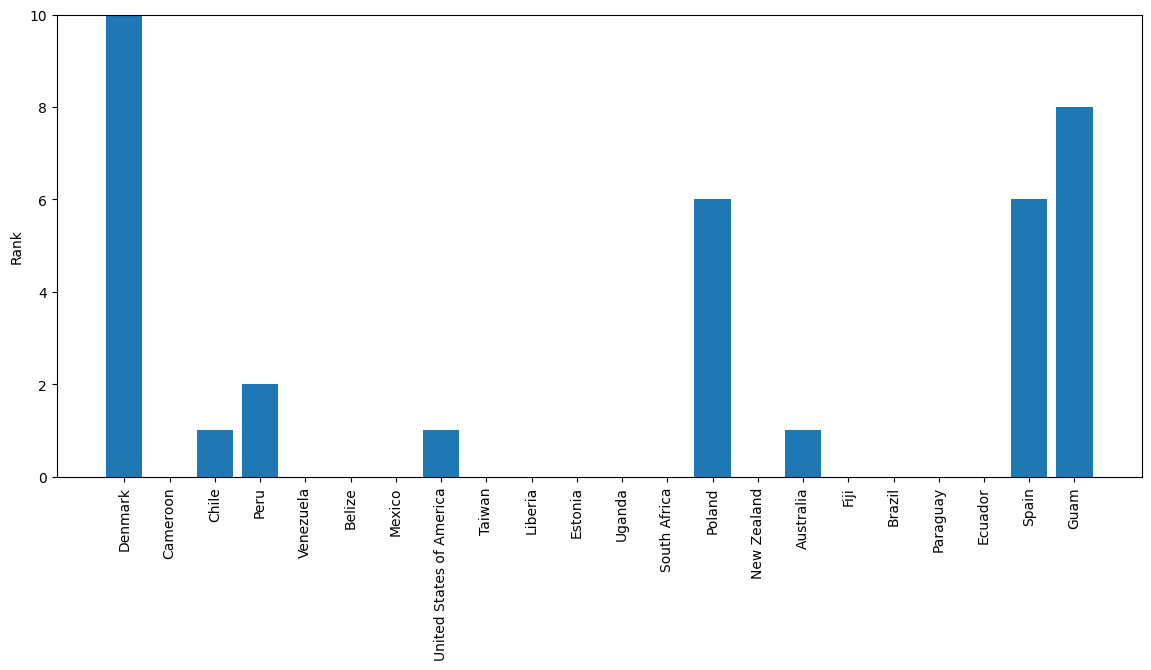

In [103]:
fig = plt.figure(figsize = (14, 6))
plt.bar(country_names, ranking)
plt.xticks(rotation=90)
plt.ylim((0, 10))
plt.ylabel("Rank")
plt.show()

### Log model

In [104]:
with mlflow.start_run(run_id=run_id):
    mlflow.pytorch.log_model(model, "model")

## Register model
Compare models and push to producton

In [108]:
#For now use the UI

In [138]:
best_run = mlflow.search_runs(order_by=["metrics.test_avg_rank ASC"]).iloc[0]
mlflow.register_model(f"runs:/{best_run.run_id}/model", "Model")

Registered model 'Model' already exists. Creating a new version of this model...
Created version '2' of model 'Model'.


<ModelVersion: aliases=[], creation_timestamp=1714761765025, current_stage='None', description=None, last_updated_timestamp=1714761765025, name='Model', run_id='e6e9ca159b304b7ab1224f65240f6d5b', run_link=None, source='file:///Users/jortdejong/GitHub/country-guess/mlruns/0/e6e9ca159b304b7ab1224f65240f6d5b/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>